База курс акций Лукойла.

1. Обучение простой сети для прогнозирования временного ряда (только close) и визуализация результата.

2. Прогнозирование на 10 шагов вперёд прямым способом и визуализация результата.

3. Графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Другая сеть, которая использует Conv1D слои.


## Подготовка данных

Загрузка библиотек

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка базы

In [ ]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('18_19.csv', sep=';')

In [ ]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [ ]:
# Просмотр размерностей получившихся табли

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Пример данных одного датасета
d = data18_19

print(d.shape[0])  # Всего записей (строк)
print(d.shape[1])  # Количество столбцов
print(d.iloc[0])   # Пример нулевой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17, data18_19]).to_numpy()

In [ ]:
# Просмотр размерности новой таблицы

print(data16_17.shape)
print(data18_19.shape)
print(data.shape)

(263925, 5)
(217947, 5)
(481872, 5)


In [ ]:
# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

Иллюстрация данных в графическом виде

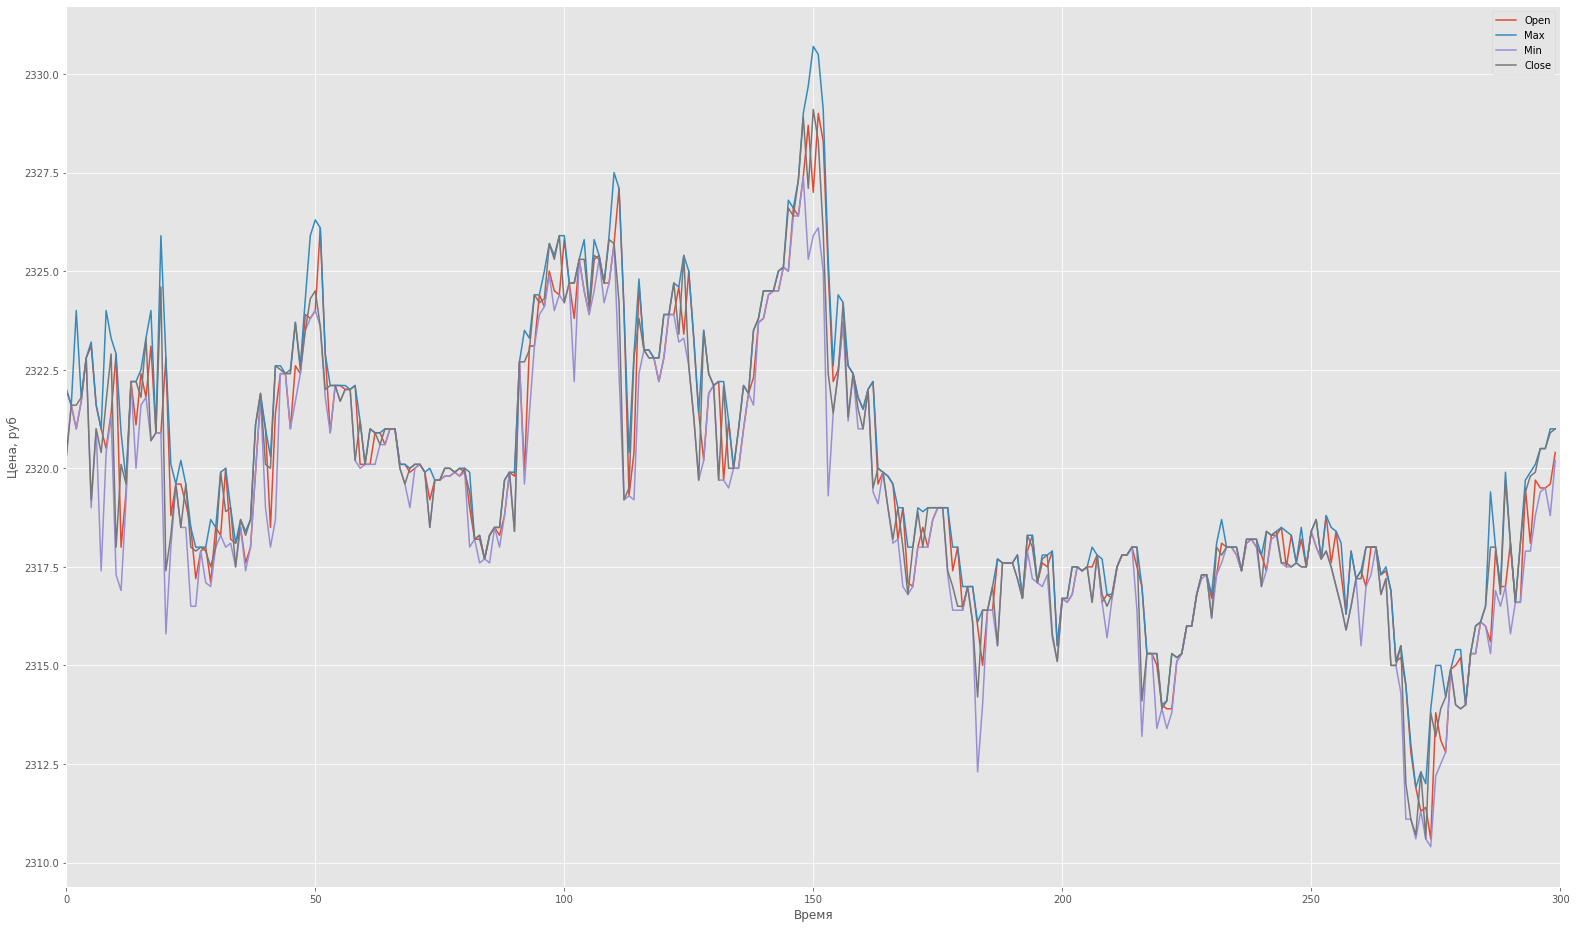

In [ ]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()

In [ ]:
# Формирование параметров загрузки данных

xLen = 300                      # Анализ по 300 (300  минут) прошедшим точкам
valLen = 30000                  # Использование 30000 записей (данных) для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Деление данных на тренировочную и тестовую выборки
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

# Масштабирование данных (отдельно для X и Y), чтобы их легче было обработать
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
print(xTrain[0])
print(xTest[0])

# Преобразование размерности,т. к. используется один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)



[0.07839171 0.07822035 0.07839814 0.07810564 0.00059283]
[7.79871033e-01 7.79570029e-01 7.80161400e-01 7.79640446e-01
 1.38722694e-04]


In [ ]:

# Создание генератора для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, #выборки
                                   length=xLen, # для каждой точки из xLen
                                   stride=1, # на сколько элементов сдвиг можно  xLen//3 делённый на какоето число, чем больше шаг тем меньше примеров
                                   sampling_rate=1, # размер шага при выборке xTrain можно взять каждый второй или третий
                                   batch_size=20 # сколько элементов вернет генератор при обращении к нему
                                   )


In [ ]:
testDataGen = TimeseriesGenerator(xTest, yTest, # Выборки
                                   length=xLen, # для каждой точки из xLen
                                   stride=1, # на сколько элементов сдвиг можно  xLen//3 делённый на какоето число, чем больше шаг тем меньше примеров
                                   batch_size=20 # сколько элементов вернет генератор при обращении к нему
                                   )


In [ ]:
# Создание генератора проверочной выборки
DataGen = TimeseriesGenerator(xTest, yTest, # Выборки
                               length=xLen, # для каждой точки из xLen
                               sampling_rate=1, # размер шага при выборке xTest
                               batch_size=len(xTest) # сколько элементов вернет генератор
                               )

# Формирование xVal, yVal для проверки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
# Функция расчета результатов прогнозирования сети

def getPred(currModel, # сеть
            xVal, # проверочная выборка, экземпляры класса
            yVal, # проверочная выборка, метки класса
            yScaler # правильные ответы в исходной размерности yValUnscaled
            ):

  # Предсказание ответа сети по проверочной выборке
  predVal = yScaler.inverse_transform(currModel.predict(xVal))

  # Использование исходного масштаба данных, до нормализации
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

# Функция визуализации графиков, которые предсказала сеть и правильных ответов

def showPredict(start, # точка, с которой начинается отрисовка графика
                step, # длина графика доя визуализации
                channel, # канал для отображения
                predVal, # предсказание ответа сети по проверочной выборке
                yValUnscaled # данные до нормализации
                ):

  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расчёта корреляции двух одномерных векторов
def correlate(a, # первый вектор
              b # второй вектор
              ):

  # Расчет основных показателей
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  # Расчет корреляции по формуле
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция визуализации корреляции прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции

def showCorr(channels, # по каким каналам отображать корреляцию
             corrSteps, # на какое количество шагов смещать сигнал назад для расчета корреляции
             predVal, # предсказание ответа сети по проверочной выборке
             yValUnscaled # данные до нормализации
             ):

  # Проход по всем каналам
  for ch in channels:
    # Создание пустого списка, в котором будут корреляции при смещении на i шагов обратно
    corr = []

    # Фиксация размера проверочной выборки
    yLen = yValUnscaled.shape[0]

    # Постепенное увеличение шага смещения сигнала для проверки автокорреляции
    for i in range(corrSteps):

      # Расчет корреляции и добавление в список
      corr.append(correlate(yValUnscaled[:yLen-i,ch], # сравнение с верными ответами, без смещения назад
                            predVal[i:, 0] # сигнал, смещенный на i шагов назад
                            ))

    # Создание пустого списка, в котором будут корреляции при смещении на i шагов обратно
    own_corr = []

    # Постепенное увеличение шага смещения сигнала для проверки автокорреляции эталона сигнала
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Вывод графика корреляции для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создание сети прямого распространения
modelD = Sequential()

modelD.add(Dense(150, input_shape = (xLen,5), activation="linear" )) # Первый слой
modelD.add(Flatten()) # Добавление выравнивающего слоя
modelD.add(Dense(yTrain.shape[1], activation="linear")) # Добавление полносвязного слоя

# Компиляция и обучение модели
modelD.compile(loss="mse",
               optimizer=Adam(lr=1e-4))



In [ ]:
 # Вывод сводки
modelD.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 300, 150)          900       
                                                                 
 flatten_6 (Flatten)         (None, 45000)             0         
                                                                 
 dense_13 (Dense)            (None, 1)                 45001     
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
22579/22579 [==============================] - 68s 3ms/step - loss: 0.0024 - val_loss: 2.1402e-05
Epoch 2/10
22579/22579 [==============================] - 68s 3ms/step - loss: 2.0923e-04 - val_loss: 7.3804e-04
Epoch 3/10
22579/22579 [==============================] - 67s 3ms/step - loss: 9.4631e-05 - val_loss: 2.5257e-04
Epoch 4/10
22579/22579 [==============================] - 66s 3ms/step - loss: 5.4258e-05 - val_loss: 9.3652e-06
Epoch 5/10
22579/22579 [==============================] - 67s 3ms/step - loss: 3.9519e-05 - val_loss: 1.3222e-05
Epoch 6/10
22579/22579 [==============================] - 67s 3ms/step - loss: 3.6358e-05 - val_loss: 5.4602e-06
Epoch 7/10
22579/22579 [==============================] - 67s 3ms/step - loss: 2.4868e-05 - val_loss: 1.0276e-05
Epoch 8/10
22579/22579 [==============================] - 66s 3ms/step - loss: 2.1313e-05 - val_loss: 1.2333e-05
Epoch 9/10
22579/22579 [==============================] - 65s 3ms/step - loss: 2.1689e-05 - val_loss

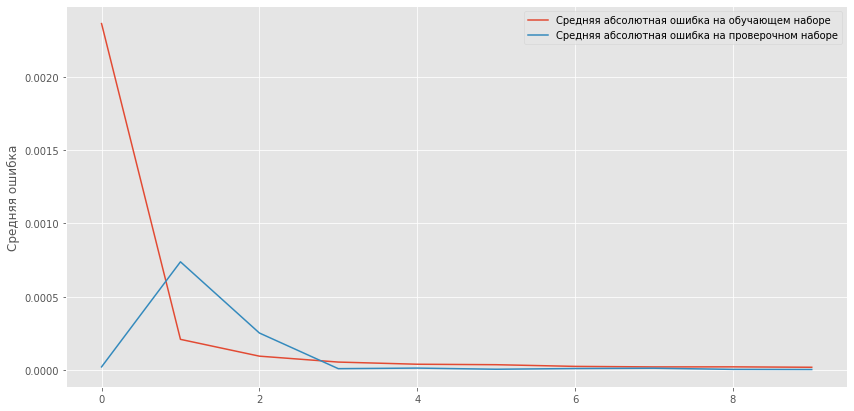

In [ ]:
history = modelD.fit(trainDataGen, # обучающая выборка
                     epochs=10, # количество эпох
                     verbose=1, # визуализация обучения
                     validation_data = testDataGen # проверочная выборка
                     )

# Вывод графиков

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

919/919 [==============================] - 2s 2ms/step


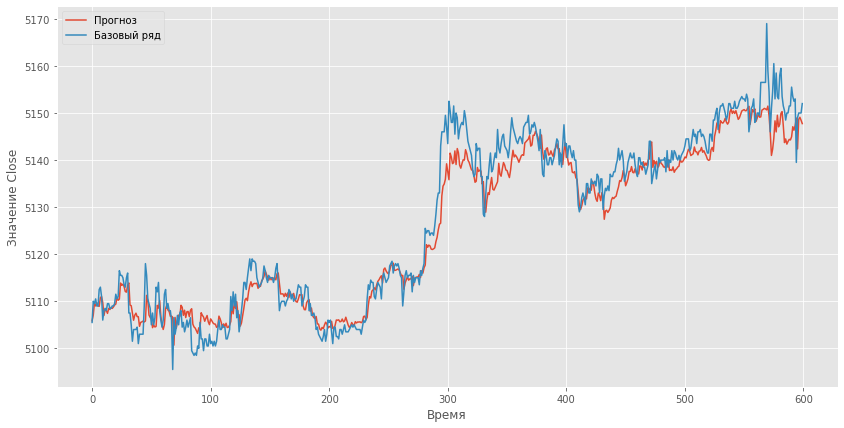

In [ ]:
# Прогноз данных текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

# Вывод графиков
showPredict(0, 600, 0, predVal, yValUnscaled)

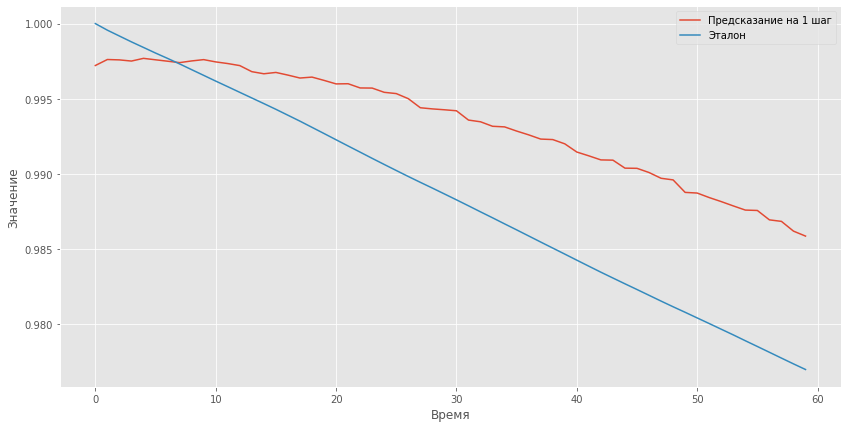

In [ ]:
# Вывод графика автокорреляции
# Использование выходного канала - только close
# Проверка корреляции на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

In [ ]:
# Формирование параметров загрузки данных

xLen = 300                      # Анализ по 300 прошедшим точкам
valLen = 30000                  # Использование 30000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Деление данных на тренировочную и тестовую выборки
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

# Масштабирование данных (отдельно для X и Y), чтобы их легче было обработать
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Преобразование размерности,т. к. используется один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

In [ ]:
# Формирование параметров загрузки данных
xLen = 300                       # Анализ по 300 прошедшим точкам
valLen = 30000                   # Использование 30000 записей для проверки
stepsForward = 10                # Шаги предсказания

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Деление данных на тренировочную и тестовую выборки
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

# Масштабирование данных (отдельно для X и Y)
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Подготовка yTrain для прогнозирования на 10 шагов вперед
yTrain = np.array([data[:trainLen,3][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,3][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создание генератора для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, # Выборки
                               length=xLen, # для каждой точки из xLen
                               sampling_rate=1, # размер шага для выборки xTrain
                               batch_size=20 # сколько элементов вернет генератор
                               )

# Создание аналогичного генератора для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest, # выборки
                               length=xLen, # для каждой точки из xLen
                               sampling_rate=1, # размер шага для выборки xTest
                               batch_size=20 # сколько элементов вернет генератор
                               )

In [ ]:
# Создание генератора проверочной выборки
DataGen = TimeseriesGenerator(xTest, yTest, # Выборки
                               length=xLen, # для каждой точки из xLen
                               sampling_rate=1, # размер шага для выборки xTest
                               batch_size=len(xTest) # сколько элементов вернет генератор
                              )

# Формирование проверочной выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

Epoch 1/10
22579/22579 [==============================] - 70s 3ms/step - loss: 0.0339 - val_loss: 0.0034
Epoch 2/10
22579/22579 [==============================] - 70s 3ms/step - loss: 0.0038 - val_loss: 3.5055e-04
Epoch 3/10
22579/22579 [==============================] - 69s 3ms/step - loss: 5.4686e-04 - val_loss: 5.2553e-04
Epoch 4/10
22579/22579 [==============================] - 70s 3ms/step - loss: 3.9148e-04 - val_loss: 2.3588e-04
Epoch 5/10
22579/22579 [==============================] - 68s 3ms/step - loss: 4.7828e-04 - val_loss: 2.8423e-04
Epoch 6/10
22579/22579 [==============================] - 69s 3ms/step - loss: 3.3792e-04 - val_loss: 2.7187e-04
Epoch 7/10
22579/22579 [==============================] - 68s 3ms/step - loss: 2.8664e-04 - val_loss: 6.7135e-04
Epoch 8/10
22579/22579 [==============================] - 68s 3ms/step - loss: 2.9211e-04 - val_loss: 1.3472e-04
Epoch 9/10
22579/22579 [==============================] - 68s 3ms/step - loss: 2.2290e-04 - val_loss: 2.3437

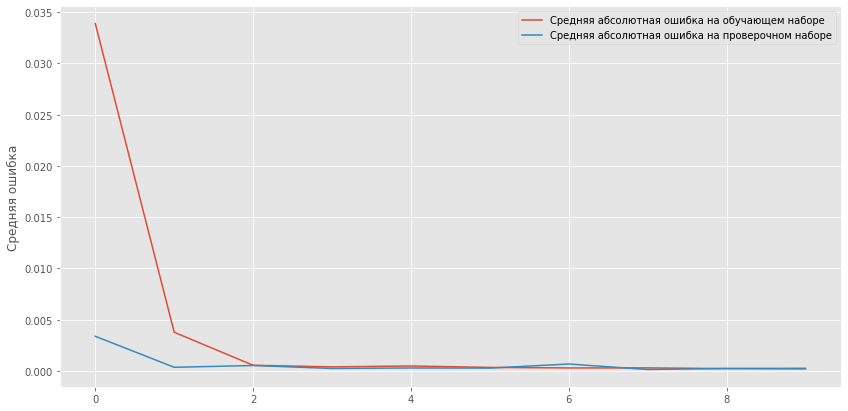

In [ ]:
# Создание сети прямого распространения
modelD = Sequential()

modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # Первый слой
modelD.add(Flatten()) # Добавление выравнивающего слоя
modelD.add(Dense(yTrain.shape[1], activation="linear")) #Добавление полносвязного слоя

# Компиляция и обучение
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelD.fit(
                    trainDataGen, # обучающая выборка
                    epochs=10, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data = testDataGen # тестовая выборка
                    )

# Вывод графиков
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

919/919 [==============================] - 2s 2ms/step


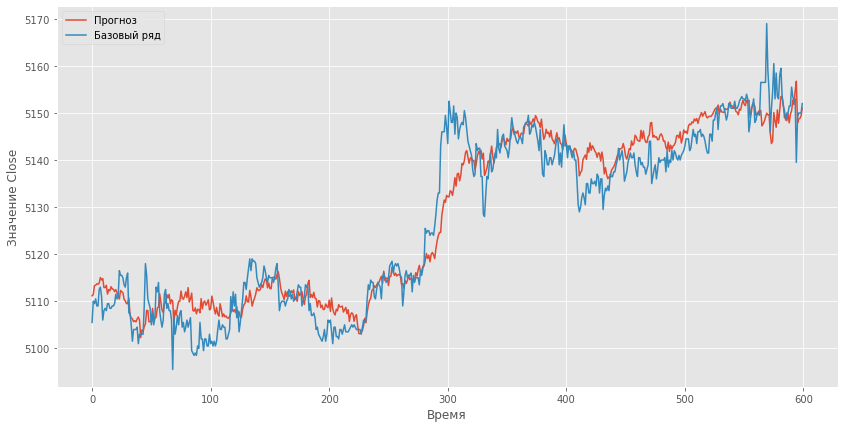

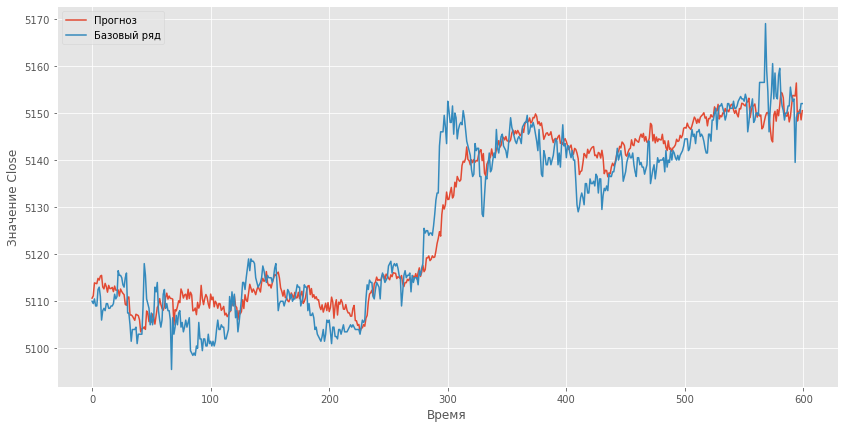

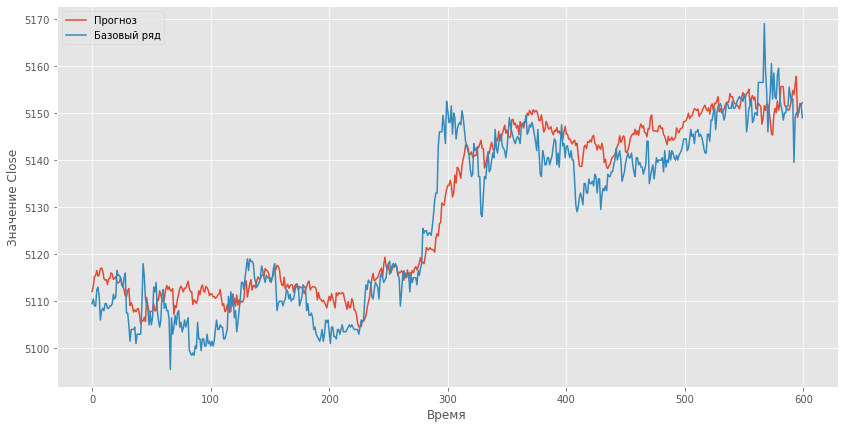

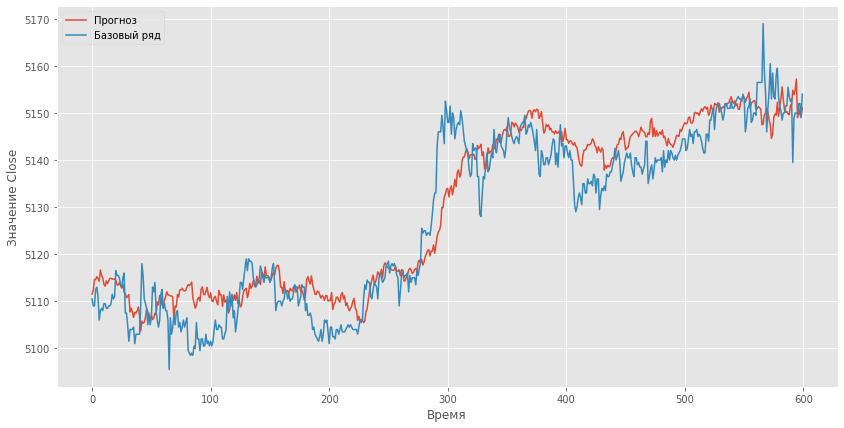

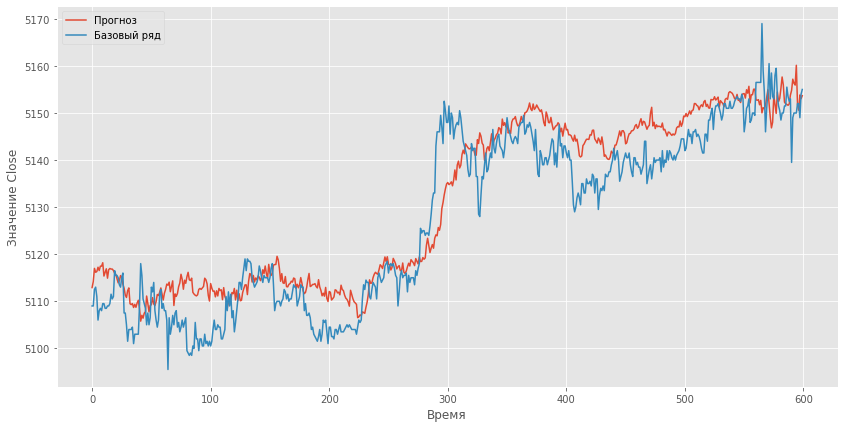

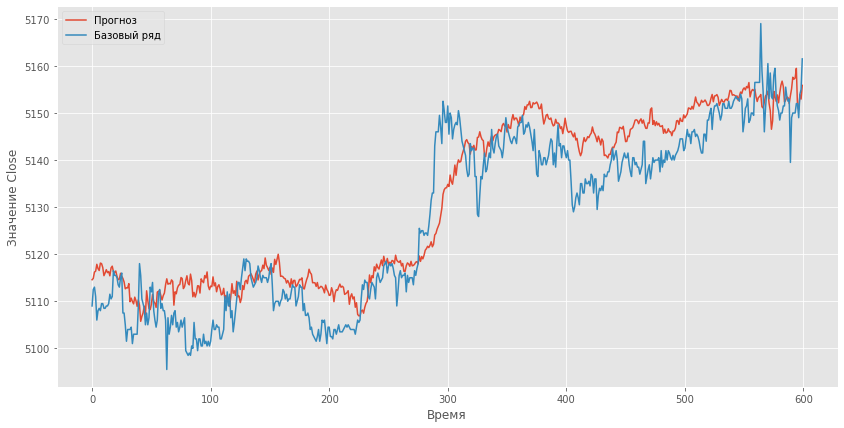

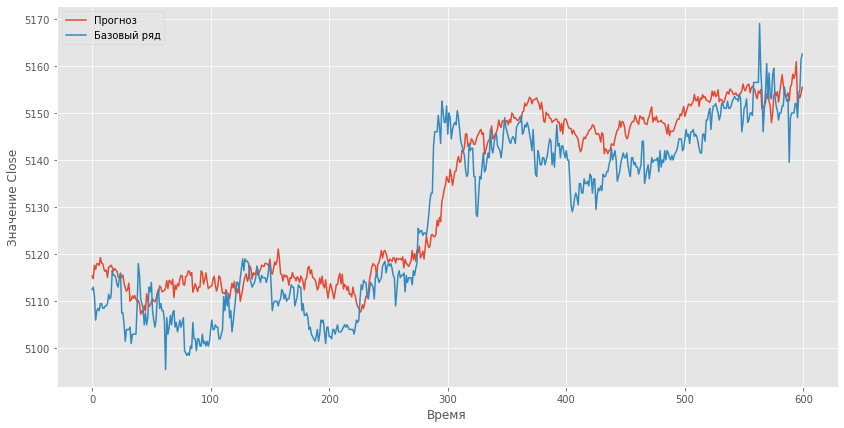

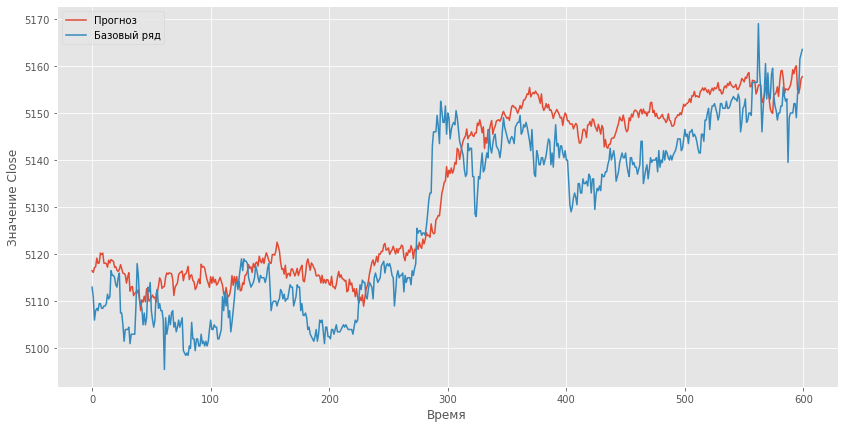

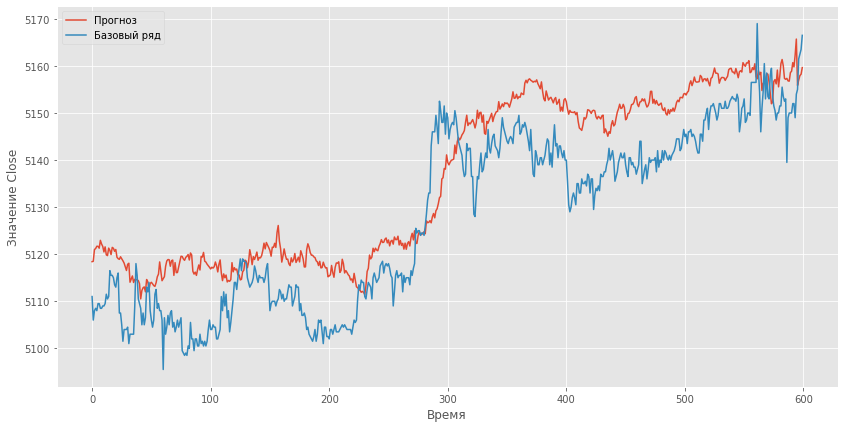

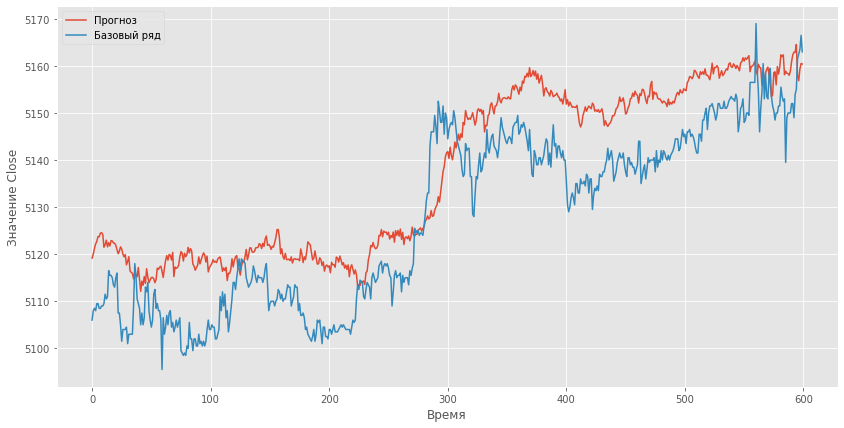

In [ ]:
# Прогноз данных текущей сетью

currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

# Вывод графиков
for i in range(10):
    showPredict(0, 600, i, predVal, yValUnscaled)

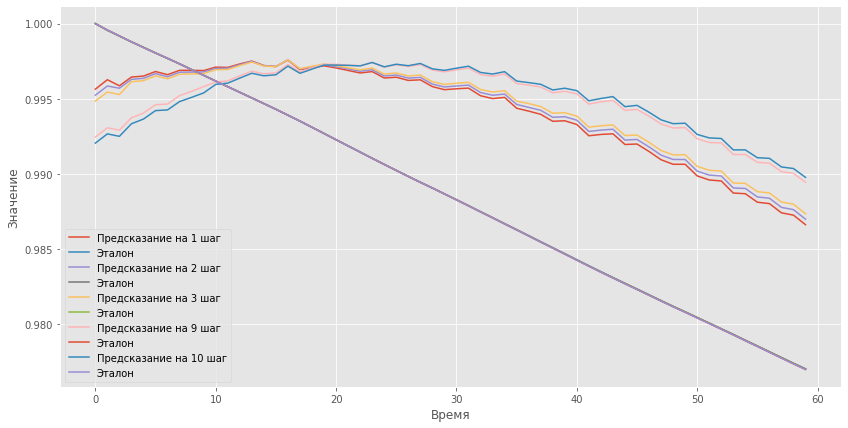

In [ ]:
# Вывод графика автокорреляции
# Использование выходного канала - только close
# Проверка корреляции на глубину 60 шагов

showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)

In [ ]:
# Создание сети прямого распросранения
modelC = Sequential()

modelC.add(Conv1D(50, 5, input_shape = (xLen,5), activation="linear")) # Первый слой
modelC.add(Flatten()) # Добавление выравнивающего слоя
modelC.add(Dense(50, activation="linear")) # Добавление полносвязного слоя
modelC.add(Dense(yTrain.shape[1], activation="linear")) # добавление полносвязного слоя

# Компиляция модели
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
modelC.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 50)           1300      
                                                                 
 flatten_8 (Flatten)         (None, 14800)             0         
                                                                 
 dense_16 (Dense)            (None, 50)                740050    
                                                                 
 dense_17 (Dense)            (None, 10)                510       
                                                                 
Total params: 741,860
Trainable params: 741,860
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
22579/22579 [==============================] - 79s 3ms/step - loss: 0.0560 - val_loss: 0.0066
Epoch 2/10
22579/22579 [==============================] - 70s 3ms/step - loss: 0.0086 - val_loss: 5.8458e-04
Epoch 3/10
22579/22579 [==============================] - 70s 3ms/step - loss: 4.9205e-04 - val_loss: 0.0063
Epoch 4/10
22579/22579 [==============================] - 71s 3ms/step - loss: 4.5912e-04 - val_loss: 1.4224e-04
Epoch 5/10
22579/22579 [==============================] - 70s 3ms/step - loss: 3.6272e-04 - val_loss: 3.2793e-04
Epoch 6/10
22579/22579 [==============================] - 69s 3ms/step - loss: 3.6574e-04 - val_loss: 7.8987e-05
Epoch 7/10
22579/22579 [==============================] - 71s 3ms/step - loss: 3.3083e-04 - val_loss: 1.3977e-04
Epoch 8/10
22579/22579 [==============================] - 69s 3ms/step - loss: 2.3501e-04 - val_loss: 2.0253e-04
Epoch 9/10
22579/22579 [==============================] - 69s 3ms/step - loss: 2.5827e-04 - val_loss: 1.6760e-04

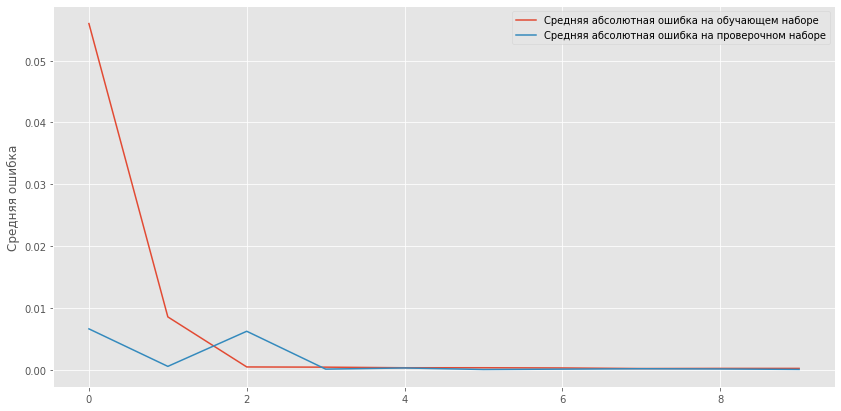

In [ ]:
# Обучение нейронной сети
history = modelC.fit_generator(trainDataGen, # обучающая выборка
                               epochs=10, # количество эпох
                               verbose=1, # визуализация обучения
                               validation_data=testDataGen # проверочная выборка
                               )

# Визуализация результетов
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

919/919 [==============================] - 2s 2ms/step


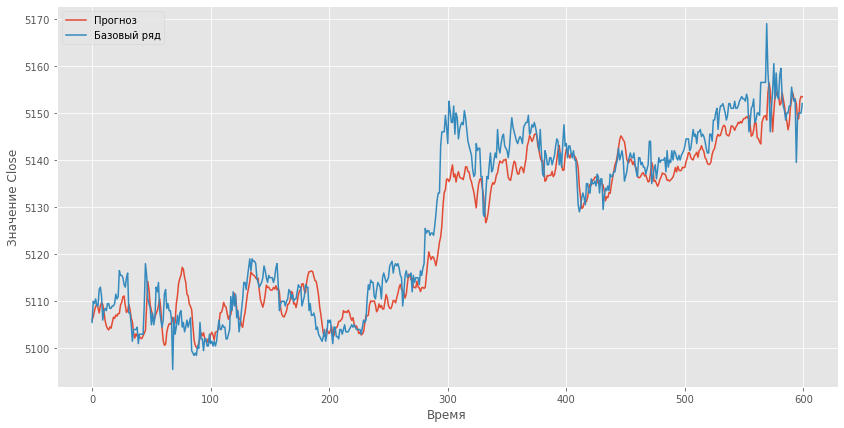

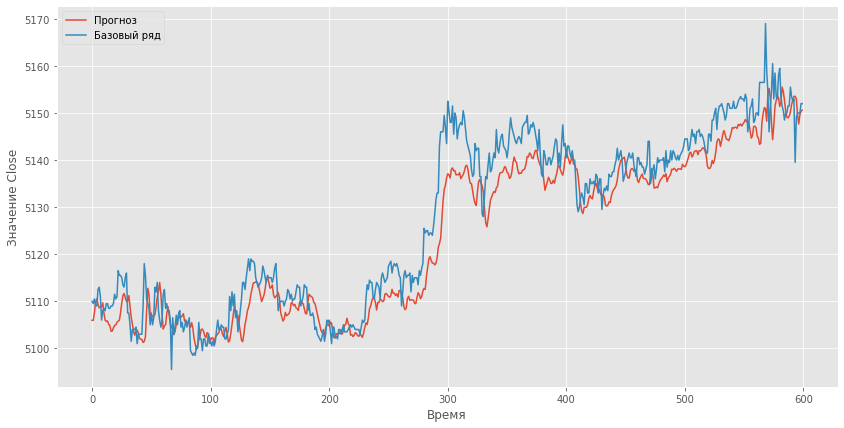

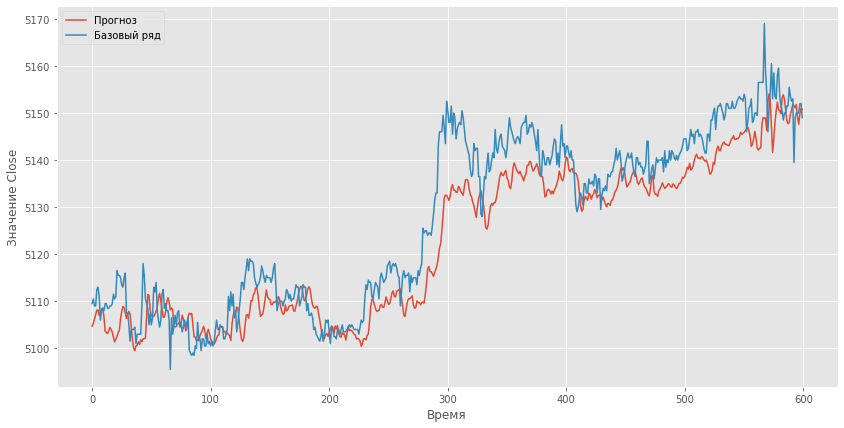

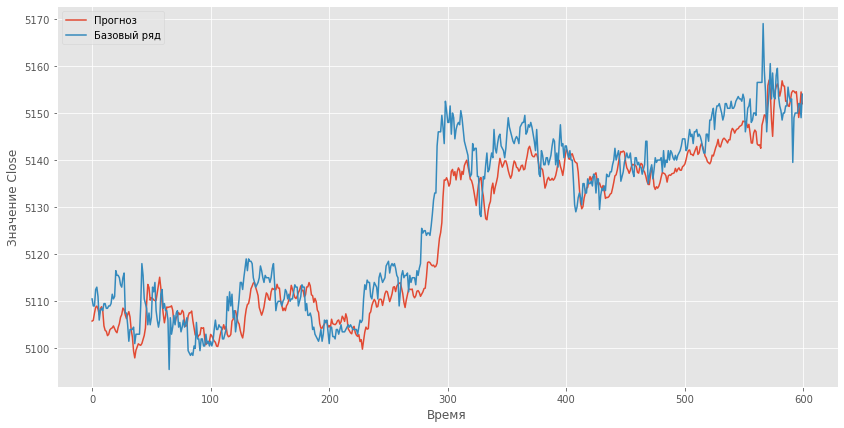

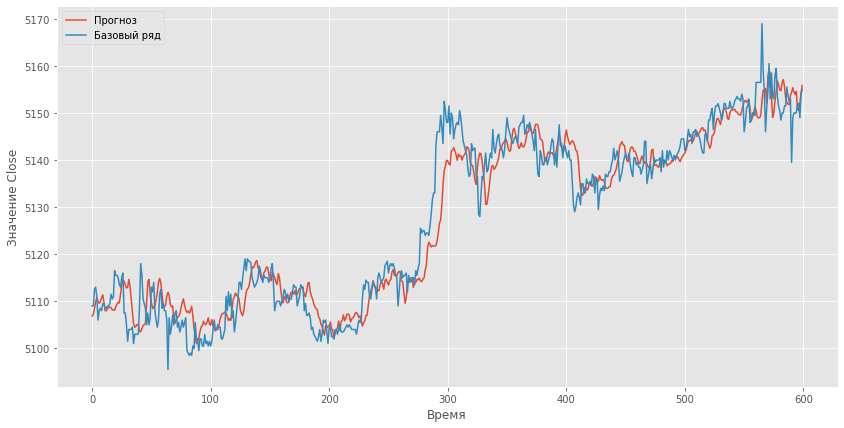

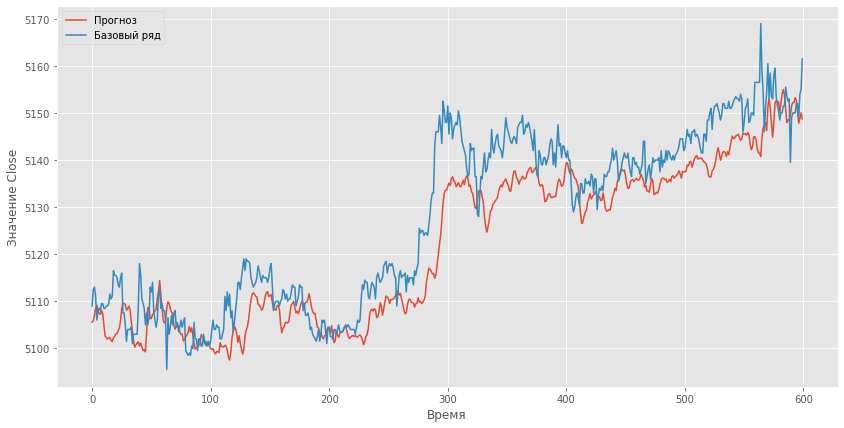

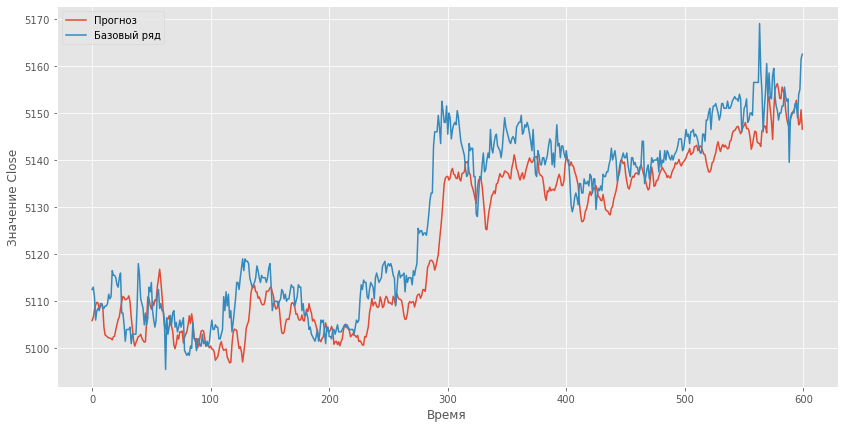

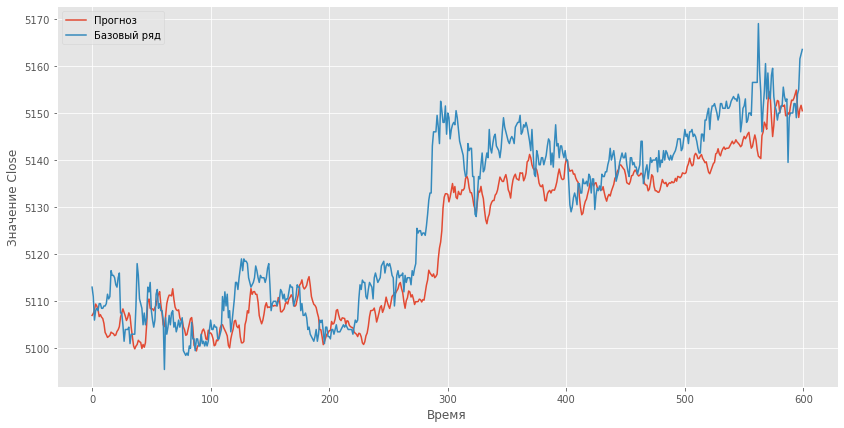

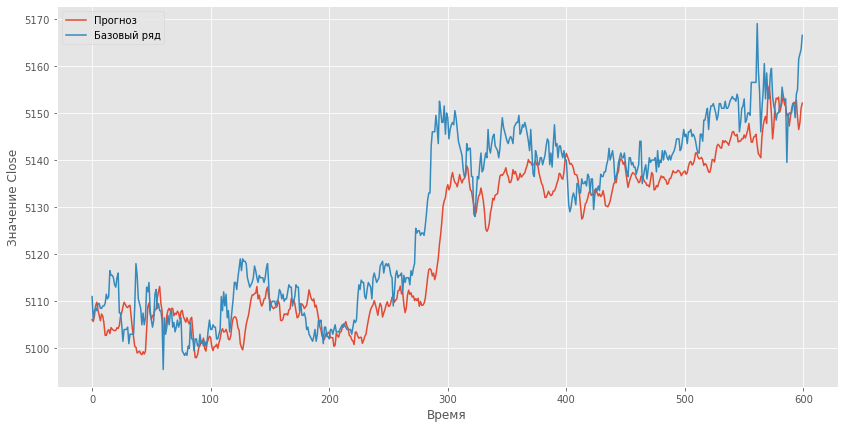

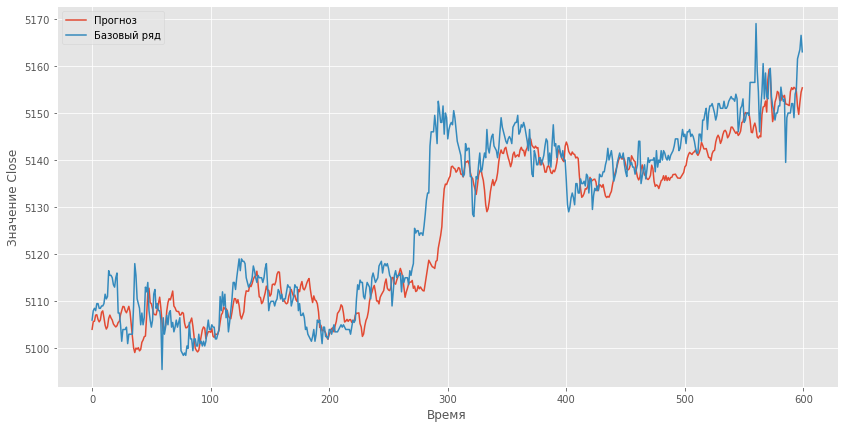

In [ ]:
# Прогноз данных текущей сетью

currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

for i in range(10):
    showPredict(0, 600, i, predVal, yValUnscaled)

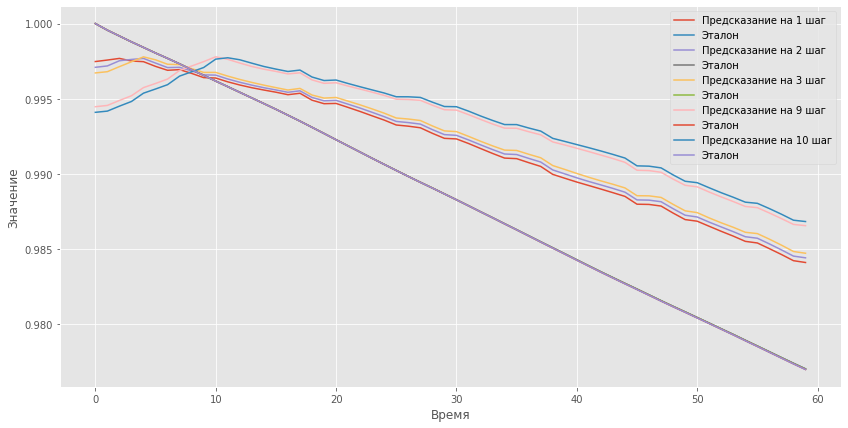

In [ ]:
# Вывод автокорреляции
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)